# Experiment with VAE AutoEncoder

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(512)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Getting the data ready

In [3]:
train_dir = '/Users/lzhan/Downloads/imaterialist-fashion-2019-FGVC6/'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(directory=train_dir,
                        batch_size=32,
                        target_size=(64,64),
                        class_mode='binary',
                        color_mode='rgb',
                        seed=42)

Found 48388 images belonging to 2 classes.


In [5]:
x_train = []
for i in range(len(train_data)):
    batch = train_data[i][0]
    x_train.append(batch)
x_train = np.concatenate(x_train, axis=0)

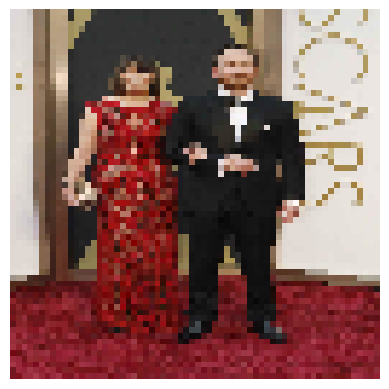

In [6]:
# Randomly plot an image
import matplotlib.pyplot as plt
random_idx = np.random.randint(0, x_train.shape[0])
plt.imshow(x_train[random_idx])
plt.axis('off')
plt.show()

## Create VAE

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return Model(input_layer, [z_mean, z_log_var, z])

def build_decoder(latent_dim, output_shape):
    input_layer = Input(shape=(latent_dim,))

    x = Dense(16 * 16 * 64, activation='relu')(input_layer)
    x = Reshape((16, 16, 64))(x)

    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    output_layer = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_layer, output_layer)

def build_vae(encoder, decoder):
    input_shape = encoder.input_shape[1:]
    latent_dim = encoder.output_shape[-1]

    inputs = Input(shape=input_shape)
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    vae = Model(inputs, outputs)
    
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae

In [8]:
latent_dim = 200
image_shape = (64, 64, 3)

encoder = build_encoder(image_shape, latent_dim)
decoder = build_decoder(latent_dim, image_shape)

vae = build_vae(encoder, decoder)
vae.compile(optimizer=Adam(lr=0.000001))

C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
epochs = 100
batch_size = 32

# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
1513/1513 [==============================] - 18s 8ms/step - loss: 8514.0361
Epoch 2/100
1513/1513 [==============================] - 13s 8ms/step - loss: 8511.0791
Epoch 3/100
1513/1513 [==============================] - 13s 8ms/step - loss: 8508.7207
Epoch 4/100
1513/1513 [==============================] - 12s 8ms/step - loss: 8507.3281
Epoch 5/100
1513/1513 [==============================] - 13s 8ms/step - loss: 8506.5957
Epoch 6/100
1513/1513 [==============================] - 13s 8ms/step - loss: 8506.1328
Epoch 7/100
1513/1513 [==============================] - 12s 8ms/step - loss: 8505.6738
Epoch 8/100
1513/1513 [==============================] - 12s 8ms/step - loss: 8504.8906
Epoch 9/100
1513/1513 [==============================] - 12s 8ms/step - loss: 8502.9854
Epoch 10/100
1513/1513 [==============================] - 12s 8ms/step - loss: 8496.8662
Epoch 11/100
1513/1513 [==============================] - 12s 8ms/step - loss: 8477.5332
Epoch 12/100
1513/1513 [======

In [10]:
def display(array1, array2, n=10):
    indices = np.random.randint(len(array2), size=n)  # Generate random indices based on the length of array2
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

4/4 [==============================] - 0s 4ms/step


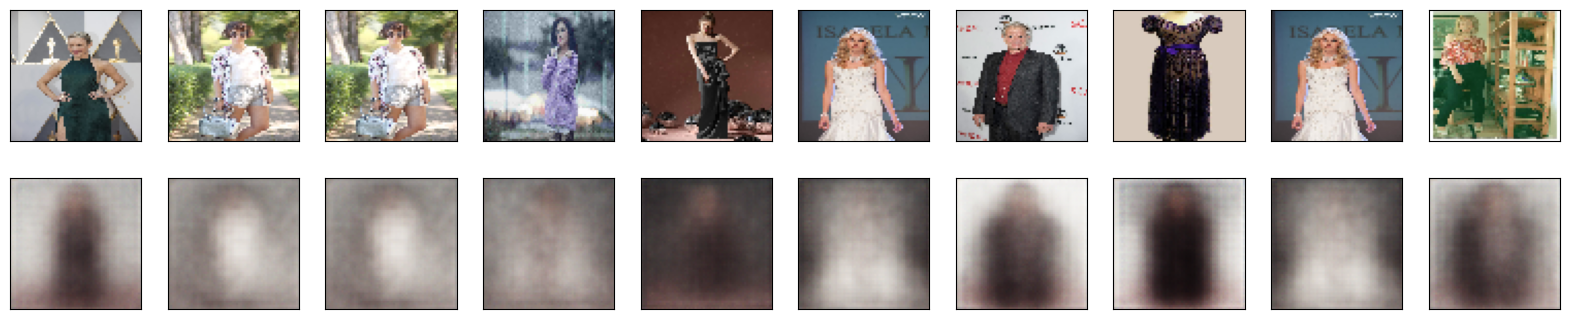

In [11]:
predictions = vae.predict(x_train[:100])
display(x_train, predictions)

## Trying to improve VAE

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return Model(input_layer, [z_mean, z_log_var, z])

def build_decoder(latent_dim, output_shape):
    input_layer = Input(shape=(latent_dim,))

    x = Dense(16 * 16 * 64, activation='relu')(input_layer)
    x = Reshape((16, 16, 64))(x)
    x = Conv2DTranspose(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    output_layer = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_layer, output_layer)

def build_vae(encoder, decoder):
    input_shape = encoder.input_shape[1:]
    latent_dim = encoder.output_shape[-1]

    inputs = Input(shape=input_shape)
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    vae = Model(inputs, outputs)
    
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae

In [13]:
latent_dim = 100
image_shape = (64, 64, 3)

encoder = build_encoder(image_shape, latent_dim)
decoder = build_decoder(latent_dim, image_shape)

vae = build_vae(encoder, decoder)
vae.compile(optimizer=Adam(lr=0.000001))
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_3 (Functional)           [(None, 100),        457368      ['input_6[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 model_4 (Functional)           (None, 256, 256, 3)  2190659     ['model_3[0][2]']                
                                                                                            

In [14]:
epochs = 200
batch_size = 32

# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/200


ResourceExhaustedError: Graph execution error:

Detected at node 'model_5/model_4/conv2d_transpose_6/conv2d_transpose' defined at (most recent call last):
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\lzhan\AppData\Local\Temp\ipykernel_5348\3565720459.py", line 5, in <module>
      vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\lzhan\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model_5/model_4/conv2d_transpose_6/conv2d_transpose'
OOM when allocating tensor with shape[32,256,256,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_5/model_4/conv2d_transpose_6/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_458788]

Because the limited of my gpu ram, I will run this in another notebook